In [1]:
from slim_gsgp_lib.main_slim import slim
from slim_gsgp_lib.utils.utils import train_test_split
from slim_gsgp_lib.evaluators.fitness_functions import rmse
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import time
import os
from tqdm import tqdm
from functions.test_funcs import mape, nrmse, r_squared, mae, standardized_rmse

from slim_gsgp_lib.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib.utils.utils import *
from functions.test_algorithms import *
from functions.random_search import * 
from slim_gsgp_lib.datasets.data_loader import *
import pickle

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

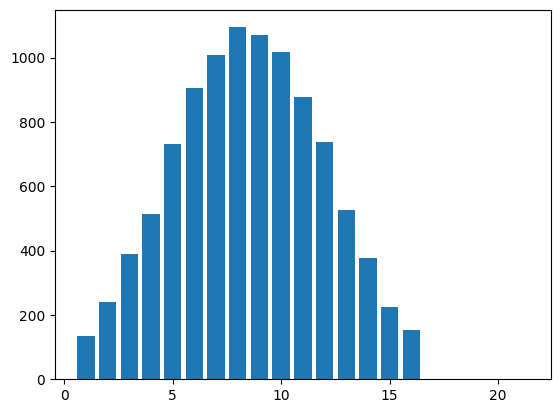

In [7]:
import matplotlib.pyplot as plt

def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

# Example usage
max_depth = 22
random_index = [1, 2,2,2,2,2]  # Example index

depths = []
for i in range(10000):
    depths.append(choose_depth(max_depth, random_index))
    
plt.hist(depths, bins=np.arange(1, max_depth + 1) - 0.5, rwidth=0.8)
plt.show()

In [11]:
X,y = datasets[2]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2)

example_tree = slim(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, dataset_name='test',
                    max_depth=22, init_depth=10, pop_size=100, n_iter=250, p_inflate=0.4, seed=1,
                    struct_mutation=True, decay_rate=0.2, p_xo=0, type_structure_mutation='new',)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.321      |      0.308      |      0.340      |        3        |   24129872703   |      5.140      |      5.140      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

|    dataset_1    |       250       |      0.118      |      0.120      |      0.168      |       165       |      5.020      |      3.350      |      0.165      |      0.081      |      17.080     |      19.510     |


In [3]:
example_tree.structure[0]

('divide',
 'constant__1.0',
 ('add',
  'x0',
  ('subtract',
   ('subtract',
    ('subtract',
     ('subtract', ('subtract', 'constant__1.0', 'x4'), ('divide', 'x4', 'x4')),
     'x4'),
    ('divide', 'x1', ('multiply', 'constant_2.0', ('divide', 'x3', 'x4')))),
   ('multiply',
    'x1',
    ('subtract',
     'x1',
     ('divide', 'x3', ('divide', 'constant_2.0', 'constant__1.0')))))))

In [15]:
indices_with_levels = get_indices_with_levels(example_tree.structure[0])
valid_indices_with_levels = [(index, level) for index, level in indices_with_levels if 22 - len(index) >= 2]


valid_indices, valid_levels = zip(*valid_indices_with_levels)
probs = exp_decay_prob(max(valid_levels) + 1, decay_rate=0.2)
level_probs = [probs[level] for level in valid_levels]
random_index = random.choices(valid_indices, weights=level_probs)[0]

In [4]:
indices_list = get_indices_with_levels(example_tree.structure[0])

In [5]:
get_indices_with_levels(example_tree.structure[0])

[((1,), 1),
 ((1, 1), 2),
 ((1, 2), 2),
 ((1, 2, 1), 3),
 ((1, 2, 2), 3),
 ((1, 2, 2, 1), 4),
 ((1, 2, 2, 2), 4),
 ((1, 2, 2, 2, 1), 5),
 ((1, 2, 2, 2, 2), 5),
 ((1, 2, 2, 2, 2, 1), 6),
 ((1, 2, 2, 2, 2, 2), 6),
 ((1, 2, 2, 2, 2, 2, 1), 7),
 ((1, 2, 2, 2, 2, 2, 2), 7),
 ((1, 2, 2, 2, 2, 2, 2, 1), 8),
 ((1, 2, 2, 2, 2, 2, 2, 1, 1), 9),
 ((1, 2, 2, 2, 2, 2, 2, 1, 2), 9),
 ((1, 2, 2, 2, 2, 2, 2, 2), 8),
 ((1, 2, 2, 2, 2, 2, 2, 2, 1), 9),
 ((1, 2, 2, 2, 2, 2, 2, 2, 2), 9),
 ((2,), 1)]

In [14]:
exp_decay_prob(5, decay_rate=0.3)

array([0.10048537, 0.13564106, 0.18309628, 0.24715412, 0.33362317])

In [16]:
decay_prob

array([0.00026134, 0.00028883, 0.0003192 , 0.00035277, 0.00038987,
       0.00043088, 0.00047619, 0.00052628, 0.00058162, 0.00064279,
       0.0007104 , 0.00078511, 0.00086768, 0.00095894, 0.00105979,
       0.00117125, 0.00129443, 0.00143056, 0.00158102, 0.00174729,
       0.00193106, 0.00213415, 0.0023586 , 0.00260666, 0.0028808 ,
       0.00318378, 0.00351862, 0.00388868, 0.00429765, 0.00474964,
       0.00524916, 0.00580122, 0.00641134, 0.00708563, 0.00783083,
       0.00865441, 0.0095646 , 0.01057052, 0.01168223, 0.01291086,
       0.0142687 , 0.01576936, 0.01742784, 0.01926074, 0.02128641,
       0.02352512, 0.02599927, 0.02873364, 0.03175559, 0.03509535,
       0.03878636, 0.04286556, 0.04737377, 0.05235611, 0.05786245,
       0.0639479 , 0.07067336, 0.07810614, 0.08632063, 0.09539905])

In [17]:
counts_dict = {}

for i in range(10000):
    random_index = random.choices(indices_list, weights=decay_prob)[0]
    if random_index in counts_dict:
        counts_dict[random_index] += 1
    else:
        counts_dict[random_index] = 1

In [18]:
counts_dict

{(2, 2, 2, 2, 2): 929,
 (2, 1, 1, 1, 2): 97,
 (1, 2, 1): 15,
 (2, 1, 2, 2, 2): 267,
 (2, 2, 1): 317,
 (2, 1, 2, 1, 2): 195,
 (2, 2, 1, 2, 1): 426,
 (2, 2, 2, 2): 802,
 (2, 2, 2, 2, 1): 887,
 (2, 2, 2): 535,
 (1, 2, 2): 38,
 (2, 2, 1, 2): 409,
 (2, 2, 1, 2, 2): 467,
 (2, 1, 2, 1, 1): 163,
 (2, 2, 2, 1): 578,
 (2, 2): 297,
 (2, 2, 1, 1): 337,
 (2, 1, 2, 1): 177,
 (2, 2, 2, 1, 2): 712,
 (2, 1, 1, 2, 1): 103,
 (2, 1, 2): 140,
 (2, 2, 2, 1, 1): 603,
 (1, 2, 1, 1, 2): 12,
 (1, 2): 10,
 (1, 2, 2, 1, 2): 43,
 (2, 1, 2, 2, 1): 217,
 (1, 2, 2, 2, 1): 45,
 (2, 1): 55,
 (2, 1, 1, 2, 2): 118,
 (2, 1, 1): 76,
 (2, 1, 2, 2): 203,
 (2, 1, 1, 1, 1): 81,
 (1, 2, 2, 2, 2): 58,
 (1, 2, 1, 2, 2): 21,
 (1, 2, 1, 1, 1): 17,
 (1, 1, 1): 8,
 (1, 1, 1, 2, 1): 7,
 (2, 1, 1, 1): 80,
 (1, 2, 2, 1, 1): 40,
 (1, 2, 2, 1): 31,
 (2, 1, 1, 2): 117,
 (2,): 64,
 (1, 1): 3,
 (1, 1, 1, 2): 10,
 (1, 2, 2, 2): 42,
 (1, 1, 2, 2): 12,
 (1, 2, 1, 2): 20,
 (1, 1, 2, 1): 6,
 (1, 2, 1, 1): 16,
 (1, 2, 1, 2, 1): 22,
 (1, 1, 2): 9,
